In [180]:
import random
# Fix the seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Primera Parte

## Emotion Classification using Fine-tuned BERT model
Credits to dair-ai https://github.com/dair-ai


In [181]:
%%capture
!pip install transformers tokenizers pytorch-lightning
!git clone https://github.com/davidtvs/pytorch-lr-finder.git
!cd pytorch-lr-finder && python setup.py install
!pip install datasets --quiet
!pip install torch_lr_finder

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [182]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
torch.__version__
from torch_lr_finder import LRFinder
import pandas as pd
from datasets import load_dataset
import numpy as np

In [183]:
data = load_dataset("dair-ai/emotion")
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Load the Pretrained Language Model
We are first going to look at pretrained language model provided by HuggingFace models. We will use a variant of BERT, called DistilRoBERTa base. The `base` model has less parameters than the `larger` model.

[RoBERTa](https://arxiv.org/abs/1907.11692) is a variant of of BERT which "*modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates*".

Knowledge distillation help to train smaller LMs with similar performance and potential.

First, let's load the tokenizer for this model:

In [184]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Now let's load the actual model with the LM head that takes care of the prediciton for the LM. When fine-tuning we don't use the head and instead use the base model. The code below shows how to do this:

In [185]:
model = AutoModelWithLMHead.from_pretrained("distilroberta-base")
base_model = model.base_model

/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/models/auto/modeling_auto.py:1748: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFo

Let's now try out the tokenizer first:

In [186]:
text = "Elvis is the king of rock!"
enc = tokenizer.encode_plus(text)
enc.keys()

dict_keys(['input_ids', 'attention_mask'])

In [187]:
print(enc)

{'input_ids': [0, 9682, 9578, 16, 5, 8453, 9, 3152, 328, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


`input_ids` are the numerical encoding of the tokens in the vocabulary. `attention_mask` is an addition option used when batching sequences together and you want to tell the model which tokens should be attented to ([read more](https://huggingface.co/transformers/glossary.html#attention-mask)). The attention mask information helps when dealing with variance in the size of sequences and we need a way to tell the model that we don't want to attend to the padded indices of the sequence.

We are only using `input_ids` and `attention_mask`

We need to also unsqueeze to simulate batch processing

Using DistilBertForSequenceClassification: https://huggingface.co/transformers/model_doc/distilbert.html#distilbertforsequenceclassification

In [188]:
out = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0), torch.tensor(enc["attention_mask"]).unsqueeze(0))
out[0].shape

torch.Size([1, 10, 768])

In [189]:
## size of representation of one of the tokens
out[0][:,0,:].shape

torch.Size([1, 768])

`torch.Size([1, 768])` represents batch_size, number of tokens in input text (lenght of tokenized text), model's output hidden size.

In [190]:
t = "Elvis is the king of rock"
enc = tokenizer.encode_plus(t)
token_representations = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0))[0][0]
print(enc["input_ids"])
print(tokenizer.decode(enc["input_ids"]))
print(f"Length: {len(enc['input_ids'])}")
print(token_representations.shape)

[0, 9682, 9578, 16, 5, 8453, 9, 3152, 2]
<s>Elvis is the king of rock</s>
Length: 9
torch.Size([9, 768])


## Building Custom Classification head on top of LM base model

Use Mish activiation function as in the one proposed in the original tutorial

In [191]:
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

The model we will use to do the fine-tuning

In [192]:
class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )

        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)

        # maybe do some pooling / RNNs... go crazy here!

        # use the <s> representation
        return self.classifier(hidden_states[0][:, 0, :])

### Pretest the model with dummy text
We want to ensure that the model is returing the right information back.

In [193]:
classifier = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, 3)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [194]:
X = torch.tensor(enc["input_ids"]).unsqueeze(0).to('cpu')
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).to('cpu')

In [195]:
classifier((X, attn))

tensor([[0.0863, 0.1556, 0.1397]], grad_fn=<AddmmBackward0>)

## Prepare your dataset for fine-tuning

In [196]:
!mkdir -p tokenizer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [197]:
## load pretrained tokenizer information
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [198]:
!ls tokenizer

merges.txt              tokenizer.json          vocab.json
special_tokens_map.json tokenizer_config.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Implement CollateFN using fast tokenizers.
This function basically takes care of proper tokenization and batches of sequences. This way you don't need to create your batches manually. Find out more about Tokenizers [here](https://github.com/huggingface/tokenizers/tree/master/bindings/python).

In [199]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])

        return (sequences_padded, attention_masks_padded), labels

## Getting the Data and Preview it
Below we are going to load the data and show you how to create the splits. However, we don't need to split the data manually becuase I have already created the splits and stored those files seperately which you can quickly download below:

In [200]:
data['train'][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [201]:
## export the datasets as txt files
## EXERCISE: Change this to an address

train_path = "train.txt"
test_path = "test.txt"
val_path = "val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]

In [202]:
## uncomment the code below to generate the text files for your train, val, and test datasets.
from sklearn.model_selection import train_test_split
import numpy as np


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": data['train']['text'], "class": data['train']['label']})
val_dataset = pd.DataFrame(data={"text": data['validation']['text'], "class": data['validation']['label']})
test_dataset = pd.DataFrame(data={"text": data['test']['text'], "class": data['test']['label']})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(test_path, sep=";",header=False, index=False)
test_dataset.to_csv(val_path, sep=";",header=False, index=False)


## Create the Dataset object

Create the Dataset object that will be used to load the different datasets.

In [203]:
import pandas as pd
from torch.utils.data import Dataset

class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "label"
        # Read the CSV file assuming it's in 'train.txt' format
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column])

    def __getitem__(self, idx):
        # Extract the text and label from the DataFrame row
        text = self.data.iloc[idx][self.data_column]
        label = int(self.data.iloc[idx][self.class_column])  # Ensure label is an integer
        return text, label

    def __len__(self):
        return len(self.data)

Sanity check

In [204]:
ds = EmoDataset(train_path)
print(ds[20])

('i feel irritated and rejected without anyone doing anything or saying anything', 3)


In [205]:
label2int

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [206]:
import tqdm

## Training with PyTorchLightning

[PyTorchLightning](https://www.pytorchlightning.ai/) is a library that abstracts the complexity of training neural networks with PyTorch. It is built on top of PyTorch and simplifies training.

![](https://pytorch-lightning.readthedocs.io/en/latest/_images/pt_to_pl.png)

In [207]:
## Methods required by PyTorchLightning

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, len(emotions))
        self.loss = nn.CrossEntropyLoss() ## combines LogSoftmax() and NLLLoss()
        #self.hparams = hparams
        self.hparams.update(vars(hparams))

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}

    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")

    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)

    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )

    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        ## use AdamW optimizer -- faster approach to training NNs
        ## read: https://www.fast.ai/2018/07/02/adam-weight-decay/
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

## Evaluating with RoBERTa baseline first.

In [208]:
from tqdm import tqdm
from sklearn.metrics import classification_report
import torch

# Detectar dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear una instancia temporal solo para la evaluación
hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=32,
    warmup_steps=100,
    epochs=1,
    lr=1e-5,
    accumulate_grad_batches=1
)

# Crear una instancia de TrainingModule con el modelo base existente
baseline_module = TrainingModule(hparams_tmp)
baseline_module.model = EmoModel(base_model, len(emotions))
baseline_module = baseline_module.to(device)  # Mover el módulo al dispositivo adecuado

# Función de evaluación
def evaluate_baseline(module):
    module.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in tqdm(module.test_dataloader()):
            (X, attn), y = batch
            X, attn = X.to(device), attn.to(device)  # Mover tensores al dispositivo adecuado
            outputs = module((X, attn))
            _, preds = torch.max(outputs, dim=1)

            true_labels.extend(y.tolist())
            predicted_labels.extend(preds.cpu().tolist())  # Asegurarse de que los predicados estén en la CPU

    return classification_report(true_labels, predicted_labels, target_names=emotions, digits=4)

# Ejecutar evaluación
print("DistilRoBERTa Baseline Performance:")
baseline_results = evaluate_baseline(baseline_module)
print(baseline_results)

/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/models/auto/modeling_auto.py:1748: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFo

DistilRoBERTa Baseline Performance:


100%|██████████| 63/63 [02:47<00:00,  2.65s/it]

              precision    recall  f1-score   support

     sadness     0.0000    0.0000    0.0000       550
         joy     0.0000    0.0000    0.0000       704
        love     0.0000    0.0000    0.0000       178
       anger     0.1375    1.0000    0.2418       275
        fear     0.0000    0.0000    0.0000       212
    surprise     0.0000    0.0000    0.0000        81

    accuracy                         0.1375      2000
   macro avg     0.0229    0.1667    0.0403      2000
weighted avg     0.0189    0.1375    0.0332      2000




/Users/achula/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/achula/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/achula/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Finding Learning rate for the model

The code below aims to obtain valuable information about the optimal learning rate during a pretraining run. Determine boundary and increase the leanring rate linearly or exponentially.

More: https://github.com/davidtvs/pytorch-lr-finder

In [209]:
!pip show torch-lr-finder


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /Users/achula/miniconda3/lib/python3.12/site-packages/torch_lr_finder-0.2.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Name: torch-lr-finder
Version: 0.2.1
Summary: Pytorch implementation of the learning rate range test
Home-page: https://github.com/davidtvs/pytorch-lr-finder
Author: David Silva
Author-email: davidtvs10@gmail.com
License: 
Location: /Users/achula/miniconda3/lib/python3.12/site-packages/torch_lr_finder-0.2.1-py3.12.egg
Requires: matplotlib, numpy, packaging, torch, tqdm
Required-by: 


/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/models/auto/modeling_auto.py:1748: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFo

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.41E-04


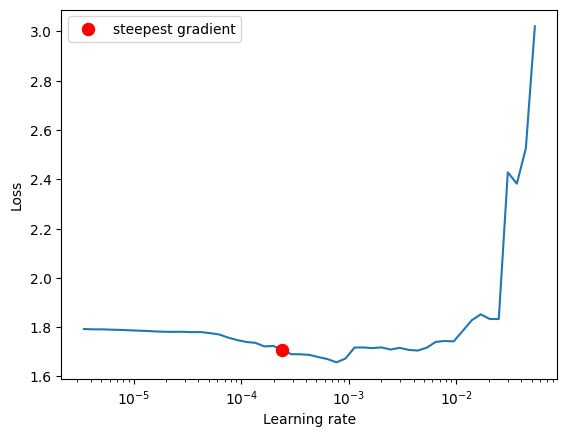

In [210]:
lr = 0.1  # Upper bound LR
from torch_lr_finder import LRFinder

# Detectar dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)

module = TrainingModule(hparams_tmp)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(module.parameters(), lr=5e-7)  # Lower bound LR

# Inicializar LRFinder con el dispositivo adecuado
lr_finder = LRFinder(module, optimizer, criterion, device=device)

# Ejecutar la prueba de rango de LR
lr_finder.range_test(module.train_dataloader(), end_lr=100, num_iter=100, accumulation_steps=hparams_tmp.accumulate_grad_batches)

# Graficar los resultados
lr_finder.plot()
lr_finder.reset()

In [211]:
lr = 1e-4
lr

0.0001

LR suggestion: steepest gradient
Suggested LR: 2.41E-04


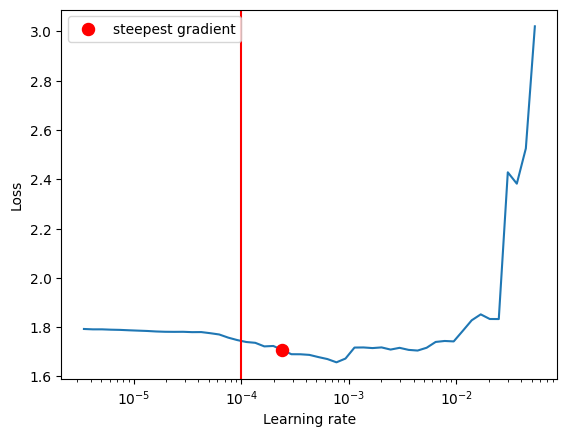

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.00024106336526516205)

In [212]:
lr_finder.plot(show_lr=lr)

## Training the Emotion Classifier

In [213]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=32,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/models/auto/modeling_auto.py:1748: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFo

In [214]:
## garbage collection
import gc; gc.collect()
torch.cuda.empty_cache()

In [215]:
# Detectar si CUDA está disponible y, en caso contrario, usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mover los tensores al dispositivo detectado
X = torch.tensor(enc["input_ids"]).unsqueeze(0).to(device)
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).to(device)

In [216]:
trainer = pl.Trainer(
    accelerator="auto",  # Usa GPU si está disponible, de lo contrario usa CPU
    devices=1,  # Especifica el número de GPUs (si está disponible)
    max_epochs=hparams.epochs,
    enable_progress_bar=True,  # Reemplaza progress_bar_refresh_rate
    accumulate_grad_batches=hparams.accumulate_grad_batches
)

# No es necesario mover manualmente el módulo a la GPU
# PyTorch Lightning lo hace automáticamente según el 'accelerator' configurado

trainer.fit(module)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | EmoModel         | 82.1 M | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
82.1 M    Trainable params
0         Non-trainable params
82.1 M    Total params
328.492   Total estimated model params size (MB)
8         Modules in train mode
117       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/achula/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/achula/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [217]:
# Determina si usar GPU o CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Asegúrate de que todo el modelo esté en el dispositivo correcto
module = module.to(device)

with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        X, attn, y = X.to(device), attn.to(device), y.to(device)  # Mueve los tensores al dispositivo correcto
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module((X, attn)), dim=1)
        true_y.extend(y.cpu())  # Mueve a CPU para almacenar resultados
        pred_y.extend(y_pred.cpu())  # Mueve a CPU para almacenar resultados
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=len(emotions)))


\
________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.968750  0.958182  0.963437       550
         joy   0.953058  0.951705  0.952381       704
        love   0.846561  0.898876  0.871935       178
       anger   0.940075  0.912727  0.926199       275
        fear   0.865471  0.910377  0.887356       212
    surprise   0.864865  0.790123  0.825806        81

    accuracy                       0.932500      2000
   macro avg   0.906463  0.903665  0.904519      2000
weighted avg   0.933254  0.932500  0.932643      2000



# Completar
1. Visualizar attention weights para algunas entradas de ejemplo del dataset.
2. Hacer una funcion que generalice la idea de arriba, toma entradas y arma un grafico de visualizacion entre palabras.
3. Cambiar tecnica de pooling para utilizar TODOS los tokens.
4. Hacer research y cambiar por otra variante de BERT, esperando que funcione mejor, reportar resultados.


## Visualización de attention weights para algunas + grafico de visualización entre palabras:

Original Text: im grabbing a minute to post i feel greedy wrong
Tokens: ['<s>', 'im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong', '</s>']


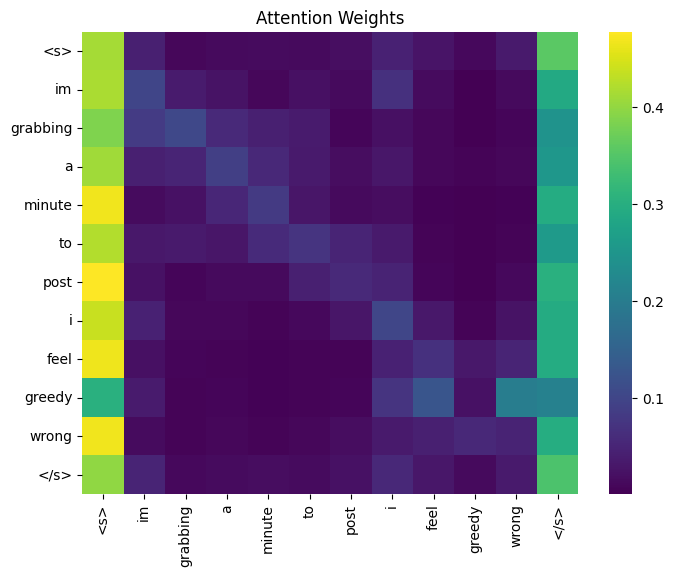

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def visualize_attention(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    attention = outputs.attentions[-1][0]  # Última capa de atención
    attention = attention.mean(0).detach().numpy()  # Promedio sobre todas las cabezas de atención

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze())
    tokens = [token.replace('Ġ', '') for token in tokens]
    
    # Print the tokens
    print(f"Tokens: {tokens}")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title('Attention Weights')
    plt.show()

# Ejemplo de uso:
# Asegúrate de acceder correctamente al texto
text = ds[2][0]  # Accediendo al primer elemento de la tupla, que debería ser el texto
print(f"Original Text: {text}")
visualize_attention(model, tokenizer, text)

## Tecnicas de Average Pooling para utilizar TODOS los tokens:

In [219]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
model = AutoModelWithLMHead.from_pretrained("distilroberta-base")
base_model = model.base_model

/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/models/auto/modeling_auto.py:1748: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initi

In [220]:
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [221]:
# fine-tuning model con promedio de tokens
class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )

        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)

        # maybe do some pooling / RNNs... go crazy here!

        # use the <s> representation
        # return self.classifier(hidden_states[0][:, 0, :])
    
        # Promediar todos los tokens
        mean_token_embeddings = torch.mean(hidden_states[0], dim=1)

        # Pasa el embedding promedio a la capa de clasificación
        return self.classifier(mean_token_embeddings)

In [222]:
## load pretrained tokenizer information
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [223]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])

        return (sequences_padded, attention_masks_padded), labels

In [224]:
class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "label"
        # Read the CSV file assuming it's in 'train.txt' format
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column])

    def __getitem__(self, idx):
        # Extract the text and label from the DataFrame row
        text = self.data.iloc[idx][self.data_column]
        label = int(self.data.iloc[idx][self.class_column])  # Ensure label is an integer
        return text, label

    def __len__(self):
        return len(self.data)

In [225]:
## Methods required by PyTorchLightning

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, len(emotions))
        self.loss = nn.CrossEntropyLoss() ## combines LogSoftmax() and NLLLoss()
        #self.hparams = hparams
        self.hparams.update(vars(hparams))

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}

    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")

    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)

    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )

    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        ## use AdamW optimizer -- faster approach to training NNs
        ## read: https://www.fast.ai/2018/07/02/adam-weight-decay/
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

### Training the Emotion Classifier

In [226]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=32,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [227]:
## garbage collection
import gc; gc.collect()
torch.cuda.empty_cache()

In [228]:
# Detectar si CUDA está disponible y, en caso contrario, usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mover los tensores al dispositivo detectado
X = torch.tensor(enc["input_ids"]).unsqueeze(0).to(device)
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).to(device)

In [229]:
trainer = pl.Trainer(
    accelerator="auto",  # Usa GPU si está disponible, de lo contrario usa CPU
    devices=1,  # Especifica el número de GPUs (si está disponible)
    max_epochs=hparams.epochs,
    enable_progress_bar=True,  # Reemplaza progress_bar_refresh_rate
    accumulate_grad_batches=hparams.accumulate_grad_batches
)

# No es necesario mover manualmente el módulo a la GPU
# PyTorch Lightning lo hace automáticamente según el 'accelerator' configurado

trainer.fit(module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | EmoModel         | 82.1 M | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
82.1 M    Trainable params
0         Non-trainable params
82.1 M    Total params
328.492   Total estimated model params size (MB)
8         Modules in train mode
117       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/achula/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/achula/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [230]:
# Determina si usar GPU o CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Asegúrate de que todo el modelo esté en el dispositivo correcto
module = module.to(device)

with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        X, attn, y = X.to(device), attn.to(device), y.to(device)  # Mueve los tensores al dispositivo correcto
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module((X, attn)), dim=1)
        true_y.extend(y.cpu())  # Mueve a CPU para almacenar resultados
        pred_y.extend(y_pred.cpu())  # Mueve a CPU para almacenar resultados
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=len(emotions)))

\
________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.967332  0.969091  0.968211       550
         joy   0.937073  0.973011  0.954704       704
        love   0.941558  0.814607  0.873494       178
       anger   0.923345  0.963636  0.943060       275
        fear   0.923858  0.858491  0.889976       212
    surprise   0.850000  0.839506  0.844720        81

    accuracy                       0.939000      2000
   macro avg   0.923861  0.903057  0.912361      2000
weighted avg   0.938978  0.939000  0.938274      2000



## deBERTa

In [231]:
from transformers import DebertaV2Tokenizer, DebertaV2Model

# Cargar el tokenizer y el modelo DeBERTa preentrenado
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")
base_model = DebertaV2Model.from_pretrained("microsoft/deberta-v3-base")

/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [232]:
import torch
import torch.nn as nn

class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model

        # Clasificador de la misma manera que antes
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            nn.ReLU(),  # Cambié Mish por ReLU para compatibilidad
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )

        # Inicializar los pesos de la capa lineal
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        # Utilizar el <s> representation
        # Promediar todos los tokens
        mean_token_embeddings = torch.mean(hidden_states[0], dim=1)
        
        # Pasar el embedding promediado a la capa de clasificación
        return self.classifier(mean_token_embeddings)

In [233]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoModel(base_model, len(emotions))
        self.loss = nn.CrossEntropyLoss()
        self.hparams = hparams
        self.hparams.update(vars(hparams))
    
    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        return {"loss": loss}
    
    def forward(self, X, *args):
        return self.model(X, *args)

    # Otras funciones como training_step, validation_step, etc. permanecen iguales.

In [244]:
trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=hparams.epochs,
    enable_progress_bar=True,
    accumulate_grad_batches=hparams.accumulate_grad_batches
)

trainer.fit(module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/achula/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type             | Params | Mode
--------------------------------------------------
0 | model | EmoModel         | 82.1 M | eval
1 | loss  | CrossEntropyLoss | 0      | eval
--------------------------------------------------
82.1 M    Trainable params
0         Non-trainable params
82.1 M    Total params
328.492   Total estimated model params size (MB)
0         Modules in train mode
125       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/achula/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/achula/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [245]:
# Determina si usar GPU o CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Asegúrate de que todo el modelo esté en el dispositivo correcto
module = module.to(device)

with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        X, attn, y = X.to(device), attn.to(device), y.to(device)  # Mueve los tensores al dispositivo correcto
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module((X, attn)), dim=1)
        true_y.extend(y.cpu())  # Mueve a CPU para almacenar resultados
        pred_y.extend(y_pred.cpu())  # Mueve a CPU para almacenar resultados
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=len(emotions)))

\
________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.962298  0.974545  0.968383       550
         joy   0.969432  0.946023  0.957584       704
        love   0.832487  0.921348  0.874667       178
       anger   0.934307  0.930909  0.932605       275
        fear   0.889952  0.877358  0.883610       212
    surprise   0.881579  0.827160  0.853503        81

    accuracy                       0.937500      2000
   macro avg   0.911676  0.912891  0.911725      2000
weighted avg   0.938470  0.937500  0.937683      2000

